# DiffDRR

> Auto-differentiable DRR synthesis and optimization in PyTorch

[![Build Status](https://github.com/eigenvivek/DiffDRR/actions/workflows/CI.yml/badge.svg?branch=main)](https://github.com/eigenvivek/DiffDRR/actions/workflows/CI.yml?query=branch%3Amain)
[![Paper shield](https://img.shields.io/badge/arXiv-2208.12737-red)](https://arxiv.org/abs/2208.12737)
[![License: MIT](https://img.shields.io/badge/License-MIT-blue)](LICENSE)
[![Downloads](https://static.pepy.tech/badge/diffdrr/month)](https://pepy.tech/project/diffdrr)
[![Docs](https://img.shields.io/badge/docs-passing-brightgreen)](https://vivekg.dev/DiffDRR/)
[![Code style: black](https://img.shields.io/badge/Code%20style-black-black.svg)](https://github.com/psf/black)

`DiffDRR` is a PyTorch-based digitally reconstructed radiograph (DRR) generator that provides

1. Auto-differentiable DRR syntheisis
2. GPU-accelerated rendering
3. A pure Python implementation

Most importantly, `DiffDRR` implements DRR synthesis as a PyTorch module, making it interoperable in deep learning pipelines.

- [Installation Guide](#installation-guide)
- [Usage](#usage)
- [Example: Rigid 2D-to-3D registration](#application-6-dof-slice-to-volume-registration)
- [How does `DiffDRR` work?](#how-does-diffdrr-work)
- [Citing `DiffDRR`](#citing-diffdrr)

## Installation Guide
<!--- 
To install `DiffDRR` with conda (recommended):
```zsh
conda install -c conda-forge diffdrr
conda install -c nvidia pytorch-cuda=11.7  # Optional for GPU support
``` 
--->

To install `DiffDRR` from PyPI:
```zsh
pip install diffdrr
```

To build `DiffDRR` from source:
```zsh
git clone https://github.com/eigenvivek/DiffDRR
conda env create -f environment.yaml
conda activate DiffDRR
```

## Usage

The following minimal example specifies the geometry of the projectional radiograph imaging system and traces rays through a CT volume:

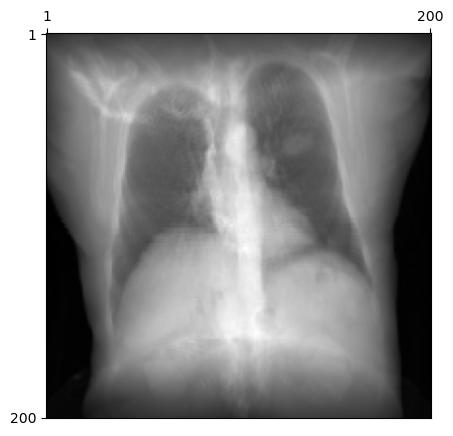

In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

# Read in the volume
volume, spacing = load_example_ct()

# Get parameters for the detector
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
detector_kwargs = {
    "sdr"   : 300.0,
    "theta" : torch.pi,
    "phi"   : 0,
    "gamma" : torch.pi / 2,
    "bx"    : bx,
    "by"    : by,
    "bz"    : bz,
}

# Make the DRR
drr = DRR(volume, spacing, height=200, delx=4.0).to("cpu")
img = drr(**detector_kwargs)

ax = plot_drr(img)
plt.show()

On a single NVIDIA RTX 2080 Ti GPU, producing such an image takes

In [ ]:
%%timeit
drr(**detector_kwargs)

1.05 s ± 89.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The full example is available at [`tutorials/introduction.ipynb`](tutorials/introduction.ipynb).

## Application: 6-DoF Slice-to-Volume Registration

We demonstrate the utility of our auto-differentiable DRR generator by solving a 6-DoF registration problem with gradient-based optimization.
Here, we generate two DRRs:

1. A fixed DRR from a set of ground truth parameters
2. A moving DRR from randomly initialized parameters

To solve the registration problem, we use gradient descent to minimize an image loss similarity metric between the two DRRs.
This produces optimization runs like this:

![](https://cdn.githubraw.com/eigenvivek/DiffDRR/7a6a44aeab58d19cc7a4afabfc5aabab3a494974/experiments/registration/results/momentum_dampen/gifs/converged/649.gif)

The full example is available at [`experiments/registration`](experiments/registration).

## How does `DiffDRR` work?

`DiffDRR` reformulates Siddon's method[^fn], the canonical algorithm for calculating the radiologic path of an X-ray through a volume, as a series of vectorized tensor operations.
This version of the algorithm is easily implemented in tensor algebra libraries like PyTorch to achieve a fast auto-differentiable DRR generator.

[^fn]: [Siddon RL. Fast calculation of the exact radiological path for a three-dimensional ct array.
Medical Physics, 2(12):252–5, 1985.](https://doi.org/10.1118/1.595715)

## Citing `DiffDRR`

If you find `DiffDRR` useful in your work, please cite our [paper](https://doi.org/10.1007/978-3-031-23179-7_1) (or the [freely accessible arXiv version](https://arxiv.org/abs/2208.12737)):

```
@inproceedings{gopalakrishnanDiffDRR2022,
    author    = {Gopalakrishnan, Vivek and Golland, Polina},
    title     = {Fast Auto-Differentiable Digitally Reconstructed Radiographs for Solving Inverse Problems in Intraoperative Imaging},
    year      = {2022},
    booktitle = {Clinical Image-based Procedures: 11th International Workshop, CLIP 2022, Held in Conjunction with MICCAI 2022, Singapore, Proceedings},
    series    = {Lecture Notes in Computer Science},
    publisher = {Springer},
    doi       = {https://doi.org/10.1007/978-3-031-23179-7_1},
}
```